In [82]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

import json 


from sklearn.metrics import accuracy_score, log_loss, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import parallel_backend
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler


In [83]:
df = pd.read_csv('robot_data/train_data.csv')

In [84]:
df.drop(columns=['year'], inplace=True)

## Shuffle dataset 

In [85]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,robot_gear_compression_diff_1,weapon_robot_armour_index_2,robot_gear_compression_diff_3,robot_gear_compression_diff_4,weapon_robot_punch_right_1,robot_gear_compression_diff_6,robot_gear_compression_diff_7,robot_gear_compression_diff_8,robot_gear_compression_diff_9,robot_gear_compression_diff_10,...,robot_probe_temperature_5,robot_probe_temperature_6,robot_probe_temperature_7,robot_probe_temperature_8,robot_probe_temperature_9,weapon_robot_eye_laser_range_1,weapon_robot_punch_left_4,weapon_robot_punch_left_2,gamma_ray,target
0,-21.473166,-21.287773,-30.439702,-66.690857,-47.987073,-16.530920,-28.607996,-23.056958,-82.100562,-38.851181,...,3.670204,-0.140208,1.317377,3.222501,1.839743,1.433567,22.619649,1.780668,high,-16.524609
1,14.416162,14.498385,15.708597,13.847628,19.363410,10.401242,18.381774,14.741960,-12.417873,19.350416,...,5.500339,0.242163,2.608532,3.223779,2.354918,1.483765,-13.017694,-256.022525,moderate,15.394629
2,-12.096272,-12.461907,-15.705488,-25.977174,-36.403429,-11.398491,-19.798178,-15.402073,-27.715333,-25.356473,...,-6.798890,-1.889365,0.870645,2.935445,1.346379,1.424815,14.191182,-2.720932,high,-8.484775
3,13.008881,12.319584,17.046516,44.910001,15.730521,11.345391,16.899036,16.216861,45.233112,18.156451,...,-16.669137,-1.551326,-0.677445,3.008708,1.434146,1.501527,-5.333896,-37.868043,moderate,9.230131
4,13.607598,15.946945,15.632170,-7.988847,9.794443,13.508486,22.731947,17.293199,-48.068992,29.980230,...,-31.557540,-3.196854,0.812429,2.616768,0.518163,0.736717,-26.675712,43.160764,low,17.404215


В этом датасете есть только 1 категориальная фича, которую мы можем кодировать или через onehot или прост сопоставить каждому значению чилсо

## encode cat features with oneHotEncoder

In [86]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

# df_oh = oneHotEncode(df, ['gamma_ray'])
# df_oh.head()

## encode cat fetures with simple encoder 

In [87]:
def simple_encode(df, encode_map=None):
    if not encode_map:
        encode_map = {'low': 0.25, 'moderate': 0.5, 'high': 0.75, 'very high': 1}

    df['gamma_ray'] = df['gamma_ray'].map(encode_map)
    return df


# df_sim = simple_encode(df)
# df_sim.head()

Мы можем засплитить наш размеченный датасет на сет для тренировки и сет для теста модели 

In [88]:
# сплит не в процентах, а в количестве семплов потому что бибу соси

def split_train_test(df, split=600, enc_type='simple'):
    if enc_type == 'simple':
        df_ = simple_encode(df.copy())
        X_train, y_train= df_.iloc[split:].drop(columns=['target'], inplace=False), df_.iloc[split:]['target']
        X_test, y_test = df_.iloc[:split].drop(columns=['target'], inplace=False), df_.iloc[:split]['target']
    elif enc_type == 'onehot':
        df_ = oneHotEncode(df.copy(), ['gamma_ray'])
        X_train, y_train = df_.iloc[split:].drop(columns=['target'], inplace=False), df_.iloc[split:]['target']
        X_test, y_test = df_.iloc[:split].drop(columns=['target'], inplace=False), df_.iloc[:split]['target']

    return X_train, y_train, X_test, y_test

# X_train, y_train, X_test, y_test = split_train_test(df, 600, 'simple')

# Save model

In [123]:
# настятельно рекомендую юзать поле enc (на каком энкодере обучалась)
# acc ввеодить без точки, eg: r2 = 0.979 => acc = 979
def save_model(model, acc, enc=''):
    json_arch = model.to_json()
    if enc:
        model.save('./models/model_{}_{}.h5'.format(acc, enc))
        with open('./arch/model_{}_{}.json'.format(acc, enc), 'w') as out:
            out.write(json_arch)
    else:
        model.save('./models/model_{}.h5'.format(acc))
        with open('./arch/model_{}.json'.format(acc), 'w') as out:
            out.write(json_arch)

## Train mlp 

Создавать все модели меняя эту функцию не самая лучшая идея, поэтому когда делаете новую модель лучше всего написать новую функцию аналагичную этой (да и вообще лучше целую секцию)

In [89]:
def create_model(n_cols):
    model = Sequential()

    model.add(Dense(128, activation='relu', input_shape=(n_cols,), kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1, activation='linear'))
    return model

r2 metric 

${R^2 = \frac{\sum{(y_i - \hat{y_i})^2}}{\sum{(y_i - \bar{y})^2}}}$

${\hat{y_i}}$ -- предсказанное значение 
${\bar{y}}$ -- среднее значение 

In [90]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [95]:
X_train, y_train, X_test, y_test = split_train_test(df, 600, 'simple')

verbose = 0 # выводить ли инфу в процессе обучения (на гитхаб лучше не заливать когда verbose > 0, а просто перетренировать с = 0)
            # 0 - silence 
            # 1 - progress bar
            # 2 - line per epoch 
model = create_model(X_train.shape[1])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])
model.summary()
history = model.fit(X_train, y_train, validation_split=0.2, epochs=400, verbose=verbose)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               18560     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 249,217
Trainable params: 249,217
Non-trainable params: 0
_________________________________________________________________


Вся инфа про обучение лежит в history

In [104]:
history.history['val_coeff_determination'][-10:]

[0.954663671650985,
 0.9532649177100376,
 0.9533832158201407,
 0.9565746234013484,
 0.9501687149616835,
 0.9580100864227896,
 0.9519670936672147,
 0.9602311026535607,
 0.9531387005693246,
 0.9597226503195055]

полный аналог r2 метрики определенной выше, но написсаный на numpy (r2 метрика выше возвращяет tensor, что нужно для использования в керасе, но это не удобно чтобы тестить)

In [105]:
def np_r2_score(v_true, v_pred):
    ssres = np.sum(np.square(v_true - v_pred))
    sstot = np.sum(np.square(v_true - np.mean(v_true)))
    return 1 - ssres / sstot

Следующие три ячейки тут потому что я так хочу 

In [106]:
y_pred = model.predict(X_test)
y_pred.shape = (y_pred.shape[0], )
np_r2_score(y_test, y_pred)

0.9794366494475739

In [107]:
(y_test - y_pred).mean()

0.32254964346765863

In [109]:
model.evaluate(X_test, y_test)

600/600 [==============================] - 0s 44us/step


[6.164404322306315, 0.9702041188875834]

In [124]:
save_model(model, 979, 'simple')

# train model on full dataset

In [127]:
def train_full_set(enc='simple', create_model=create_model, epochs=400, verbose=0):
    dataset = pd.read_csv('./robot_data/train_data.csv')    
    dataset = dataset.drop(columns=['year'])
    dataset = dataset.sample(frac=1).reset_index(drop=True)
    X_train, y_train, X_test, y_test = split_train_test(dataset, 0, enc)
    model = create_model(X_train.shape[1])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])
    model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, verbose=verbose)
    return model 

In [128]:
model = train_full_set()

model.evaluate(X_train, y_train)

2663/2663 [==============================] - 0s 50us/step


[2.036161985565879, 0.9900444393940452]

# try learn not only nn's

In [135]:
regressors = [
    Lasso(),
    ElasticNet(),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor()]

In [142]:
dataset = pd.read_csv('./robot_data/train_data.csv') 
dataset = dataset.sample(frac=1).reset_index(drop=True)

скейлим датасет и сопоставляем значения категориям 

In [143]:
dataset = simple_encode(dataset)

X = dataset.values[0::, :-2:]
y = dataset.values[0::, -1]

scaler = StandardScaler()

X = scaler.fit_transform(X)
X = np.c_[(X, dataset.values[0::, -2])]

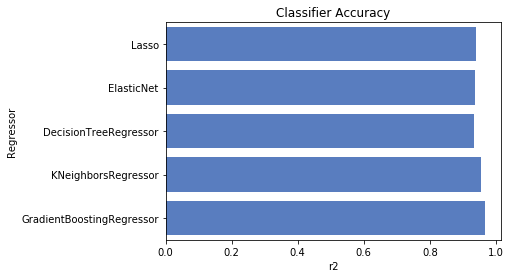

In [144]:
log_cols = ["Regressor", "r2"]
log = pd.DataFrame(columns=log_cols)

acc_dict = {}

for reg in regressors:
    name = reg.__class__.__name__
    
    acc = cross_validate(reg, X, y, scoring=['r2', 'neg_mean_squared_error'], cv=3, n_jobs=-1)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for reg in acc_dict:
    log_entry = pd.DataFrame([[reg, acc_dict[reg]['test_r2'].mean()]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='r2', y='Regressor', data=log, color="b")

# train gradiend boosting regressor

Вообще этот регрессор выглядит многообещающе, но я потратил на него уже три попытки и все были с отрицательным r2 -> я както неправильно подготавливаю данные. Скорее всего я где-то неправ со scaler'ом. А мб он прост не работает и не надо тратить на него время

In [145]:
X_train, X_test = X[600:], X[:600]
y_train, y_test = y[600:], y[:600]

gbr_reg = GradientBoostingRegressor()
gbr_reg.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [148]:
y_preds = gbr_reg.predict(X_test)

In [149]:
gbr_reg.score(X_test, y_test)

0.9926041262413985

# Predict on test set

In [153]:
def get_preds_on_test(model, enc='simple'):
    df = pd.read_csv('./robot_data/test_data.csv')
    df = df.drop(columns=['year', 'target'])
    
    if enc == 'simple':
        df = simple_encode(df.copy())
        
    elif enc == 'onehot':
        df = oneHotEncode(df.copy())
        
    y_pred = model.predict(df)
    return y_pred

# submit funcion

In [161]:
def create_submition(model, enc='simple', subm_name=None):
    df = pd.read_csv('./robot_data/test_data.csv')
    years = df['year']
    
    y_pred = get_preds_on_test(model)
    y_pred = y_pred.reshape(1000)
    
    d = {'year': years.values, 'target': y_pred}
    ans = pd.DataFrame(d)
    ans = ans.set_index('year')
    
    subm_name = subm_name if subm_name else 'submission_.csv'
    ans.to_csv(subm_name)

In [162]:
create_submition(model, subm_name='subm_gbr_bad.csv')